In [1]:
from ltrcart import LTRCart
from survival_data import SurvivalData
import pandas as pd
import sys
from lifelines import CoxPHFitter
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import graphviz 
from sklearn import tree
from matplotlib import pyplot as plt

import numpy as np
from sksurv.datasets import load_gbsg2
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import integrated_brier_score 

In [2]:
train = pd.read_csv("C:/Users/tamir/RSF_Left_Truncation/sample_data/creatinine_train.csv",index_col=0)
test = pd.read_csv("C:/Users/tamir/RSF_Left_Truncation/sample_data/creatinine_test.csv",index_col=0)

In [3]:
train.head()

,age,sex,sample.yr,kappa,lambda,FLC,creatinine,mgus,futime,death,chapter,End
1,97,F,1997,5.70,4.860,10,1.7,0,85,1,Circulatory,97.232877
2,92,F,2000,0.87,0.683,1,0.9,0,1281,1,Neoplasms,95.509589
3,94,F,1997,4.36,3.850,10,1.4,0,69,1,Circulatory,94.189041
4,92,F,1996,2.42,2.220,9,1.0,0,115,1,Circulatory,92.315068
5,93,F,1996,1.32,1.690,6,1.1,0,1039,1,Circulatory,95.846575


In [4]:
y_train = SurvivalData(train[['age','End','death']])
y_test = SurvivalData(test[['age','End','death']])

In [5]:
x_train = train.loc[:,['sex' , 'FLC' , 'creatinine']]
x_test = test.loc[:,['sex' , 'FLC' , 'creatinine']]

x_train = x_train.replace({'F':0,'M':1})
x_test = x_test.replace({'F':0,'M':1})

In [6]:
ltrc_art_obj =  LTRCart(y_train,x_train)
ltrc_art_tree = ltrc_art_obj.ltrc_art_fit()
ltrc_art_predict = ltrc_art_tree.predict(x_test)
pd.DataFrame(ltrc_art_predict).head(14)

,0
0,0.691743
1,0.691743
2,0.691743
3,0.691743
4,1.097466
5,0.413926
6,0.691743
7,1.097466
8,0.691743
9,0.691743


[Text(0.5555555555555556, 0.875, 'FLC <= 9.5\npoisson = 0.278\nsamples = 500\nvalue = 0.572'),
 Text(0.3333333333333333, 0.625, 'creatinine <= 1.25\npoisson = 0.275\nsamples = 334\nvalue = 0.668'),
 Text(0.2222222222222222, 0.375, 'FLC <= 2.5\npoisson = 0.285\nsamples = 248\nvalue = 0.738'),
 Text(0.1111111111111111, 0.125, 'poisson = 0.319\nsamples = 28\nvalue = 1.097'),
 Text(0.3333333333333333, 0.125, 'poisson = 0.269\nsamples = 220\nvalue = 0.692'),
 Text(0.4444444444444444, 0.375, 'poisson = 0.201\nsamples = 86\nvalue = 0.467'),
 Text(0.7777777777777778, 0.625, 'creatinine <= 1.95\npoisson = 0.231\nsamples = 166\nvalue = 0.379'),
 Text(0.6666666666666666, 0.375, 'poisson = 0.237\nsamples = 144\nvalue = 0.414'),
 Text(0.8888888888888888, 0.375, 'poisson = 0.097\nsamples = 22\nvalue = 0.15')]

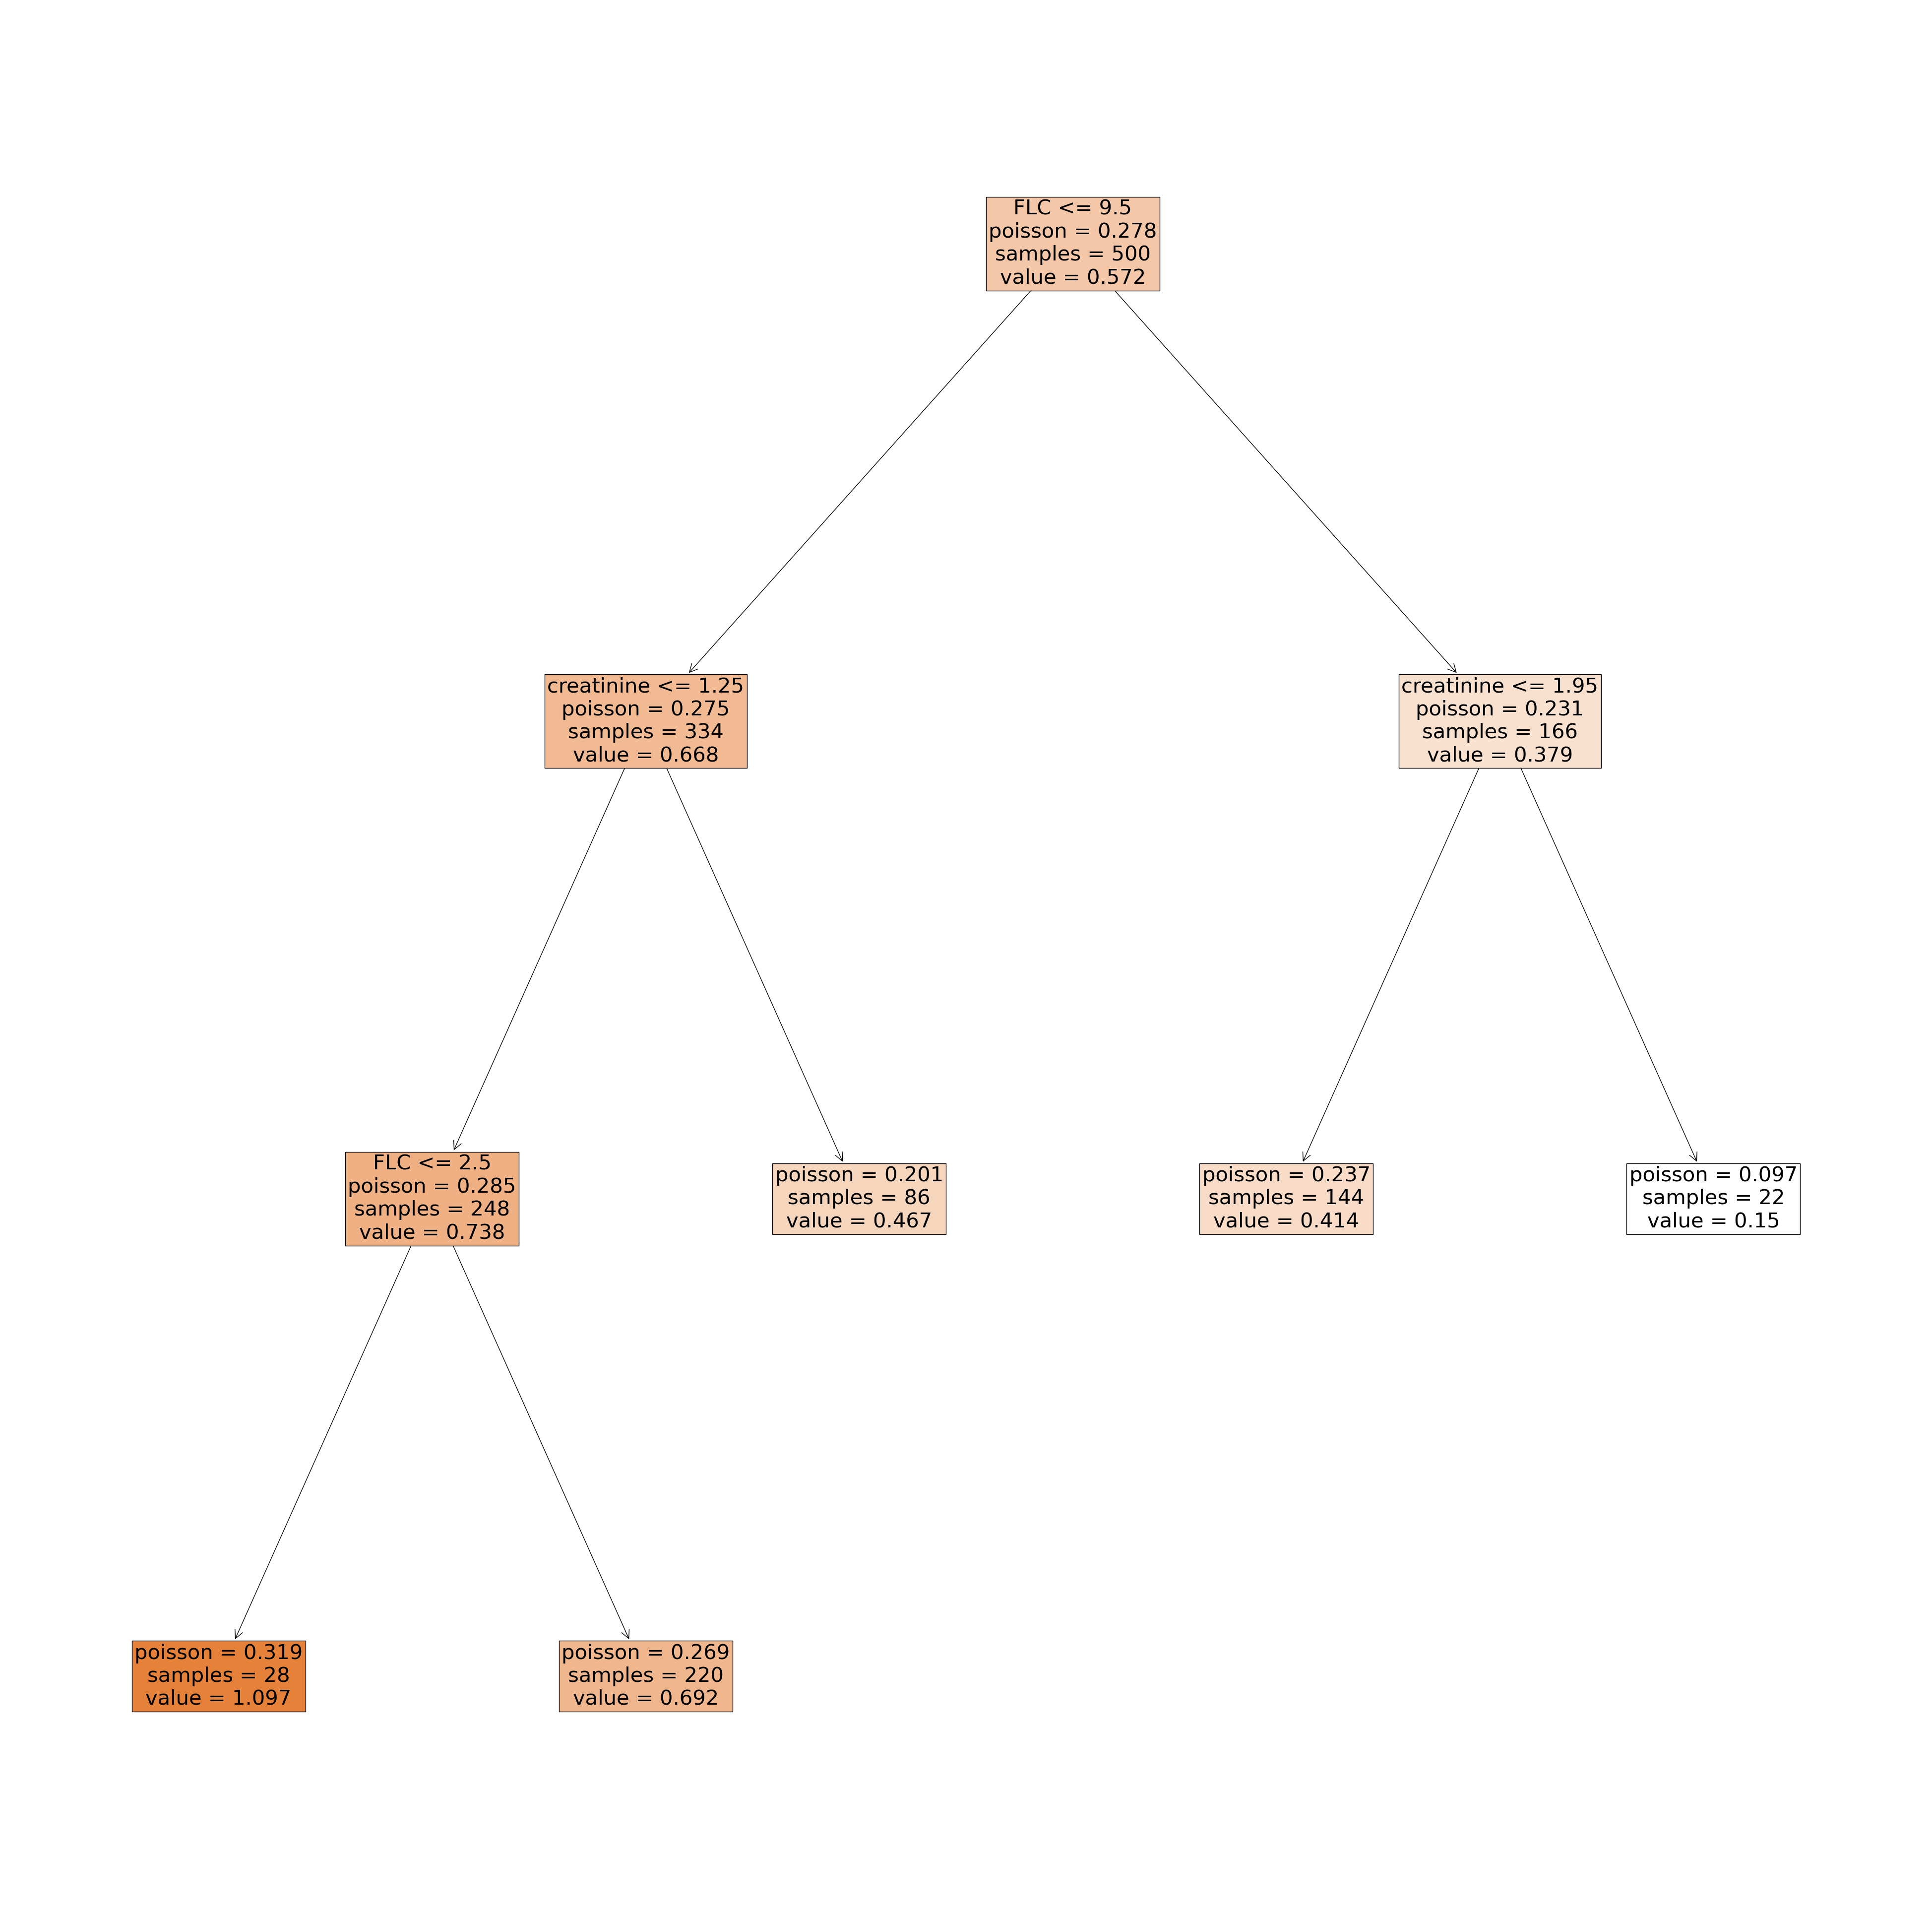

In [7]:
fig = plt.figure(figsize=(50,50))
tree.plot_tree(ltrc_art_tree,fontsize=30,feature_names=x_train.columns,filled = True)

In [8]:
def create_sim_data(dist = np.random.exponential,dist_values=[1/0.1,1/0.23,1/0.4,1/0.9],lt=1 ,heavy = False):
    x_1, x_4 = np.random.randint(1,6,10000), np.random.randint(1,6,10000)
    x_2, x_5 = np.random.randint(1,3,10000), np.random.randint(1,3,10000)
    x_3, x_6 = np.random.rand(10000)*2, np.random.rand(10000)*2
    sim_data = pd.DataFrame({'x_1':x_1,'x_2':x_2,'x_3':x_3,'x_4':x_4,'x_5':x_5,'x_6':x_6})

    sim_data['lt'] = np.random.rand(10000)*lt

    t_1=dist(dist_values[0],10000)*((sim_data.x_1<=2) & (sim_data.x_2<=1))
    t_2=dist(dist_values[1],10000)*((sim_data.x_1<=2) & (sim_data.x_2>1))
    t_3=dist(dist_values[2],10000)*((sim_data.x_1>2) & (sim_data.x_3<=1))
    t_4=dist(dist_values[3],10000)*((sim_data.x_1>2) & (sim_data.x_3>1))

    sim_data['t'] = pd.DataFrame([t_1,t_2,t_3,t_4]).max()
    sim_data = sim_data.loc[sim_data['t']>=sim_data['lt']]
    prop_cens = 0
    c=16
    min_cens = 0.5 if heavy else 0.2
    while prop_cens<=min_cens:
        sim_data['c'] = sim_data['lt']+np.random.exponential(scale=c,size=sim_data.shape[0])
        prop_cens = (sim_data['c']<sim_data['t']).sum()/sim_data.shape[0]
        c-=0.02
    sim_data['event'] = (sim_data['c'] >= sim_data['t']).astype(int)
    sim_data['t'] = sim_data[['t','c']].min(axis=1)
    return sim_data[['lt','t','event']],sim_data[['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6']]

[Text(0.5, 0.8333333333333334, 'x[0] <= 2.5\npoisson = 0.337\nsamples = 500\nvalue = 0.759'),
 Text(0.25, 0.5, 'x[1] <= 1.5\npoisson = 0.351\nsamples = 212\nvalue = 1.119'),
 Text(0.125, 0.16666666666666666, 'poisson = 0.376\nsamples = 100\nvalue = 1.401'),
 Text(0.375, 0.16666666666666666, 'poisson = 0.27\nsamples = 112\nvalue = 0.868'),
 Text(0.75, 0.5, 'x[2] <= 0.986\npoisson = 0.219\nsamples = 288\nvalue = 0.494'),
 Text(0.625, 0.16666666666666666, 'poisson = 0.217\nsamples = 167\nvalue = 0.64'),
 Text(0.875, 0.16666666666666666, 'poisson = 0.145\nsamples = 121\nvalue = 0.292')]

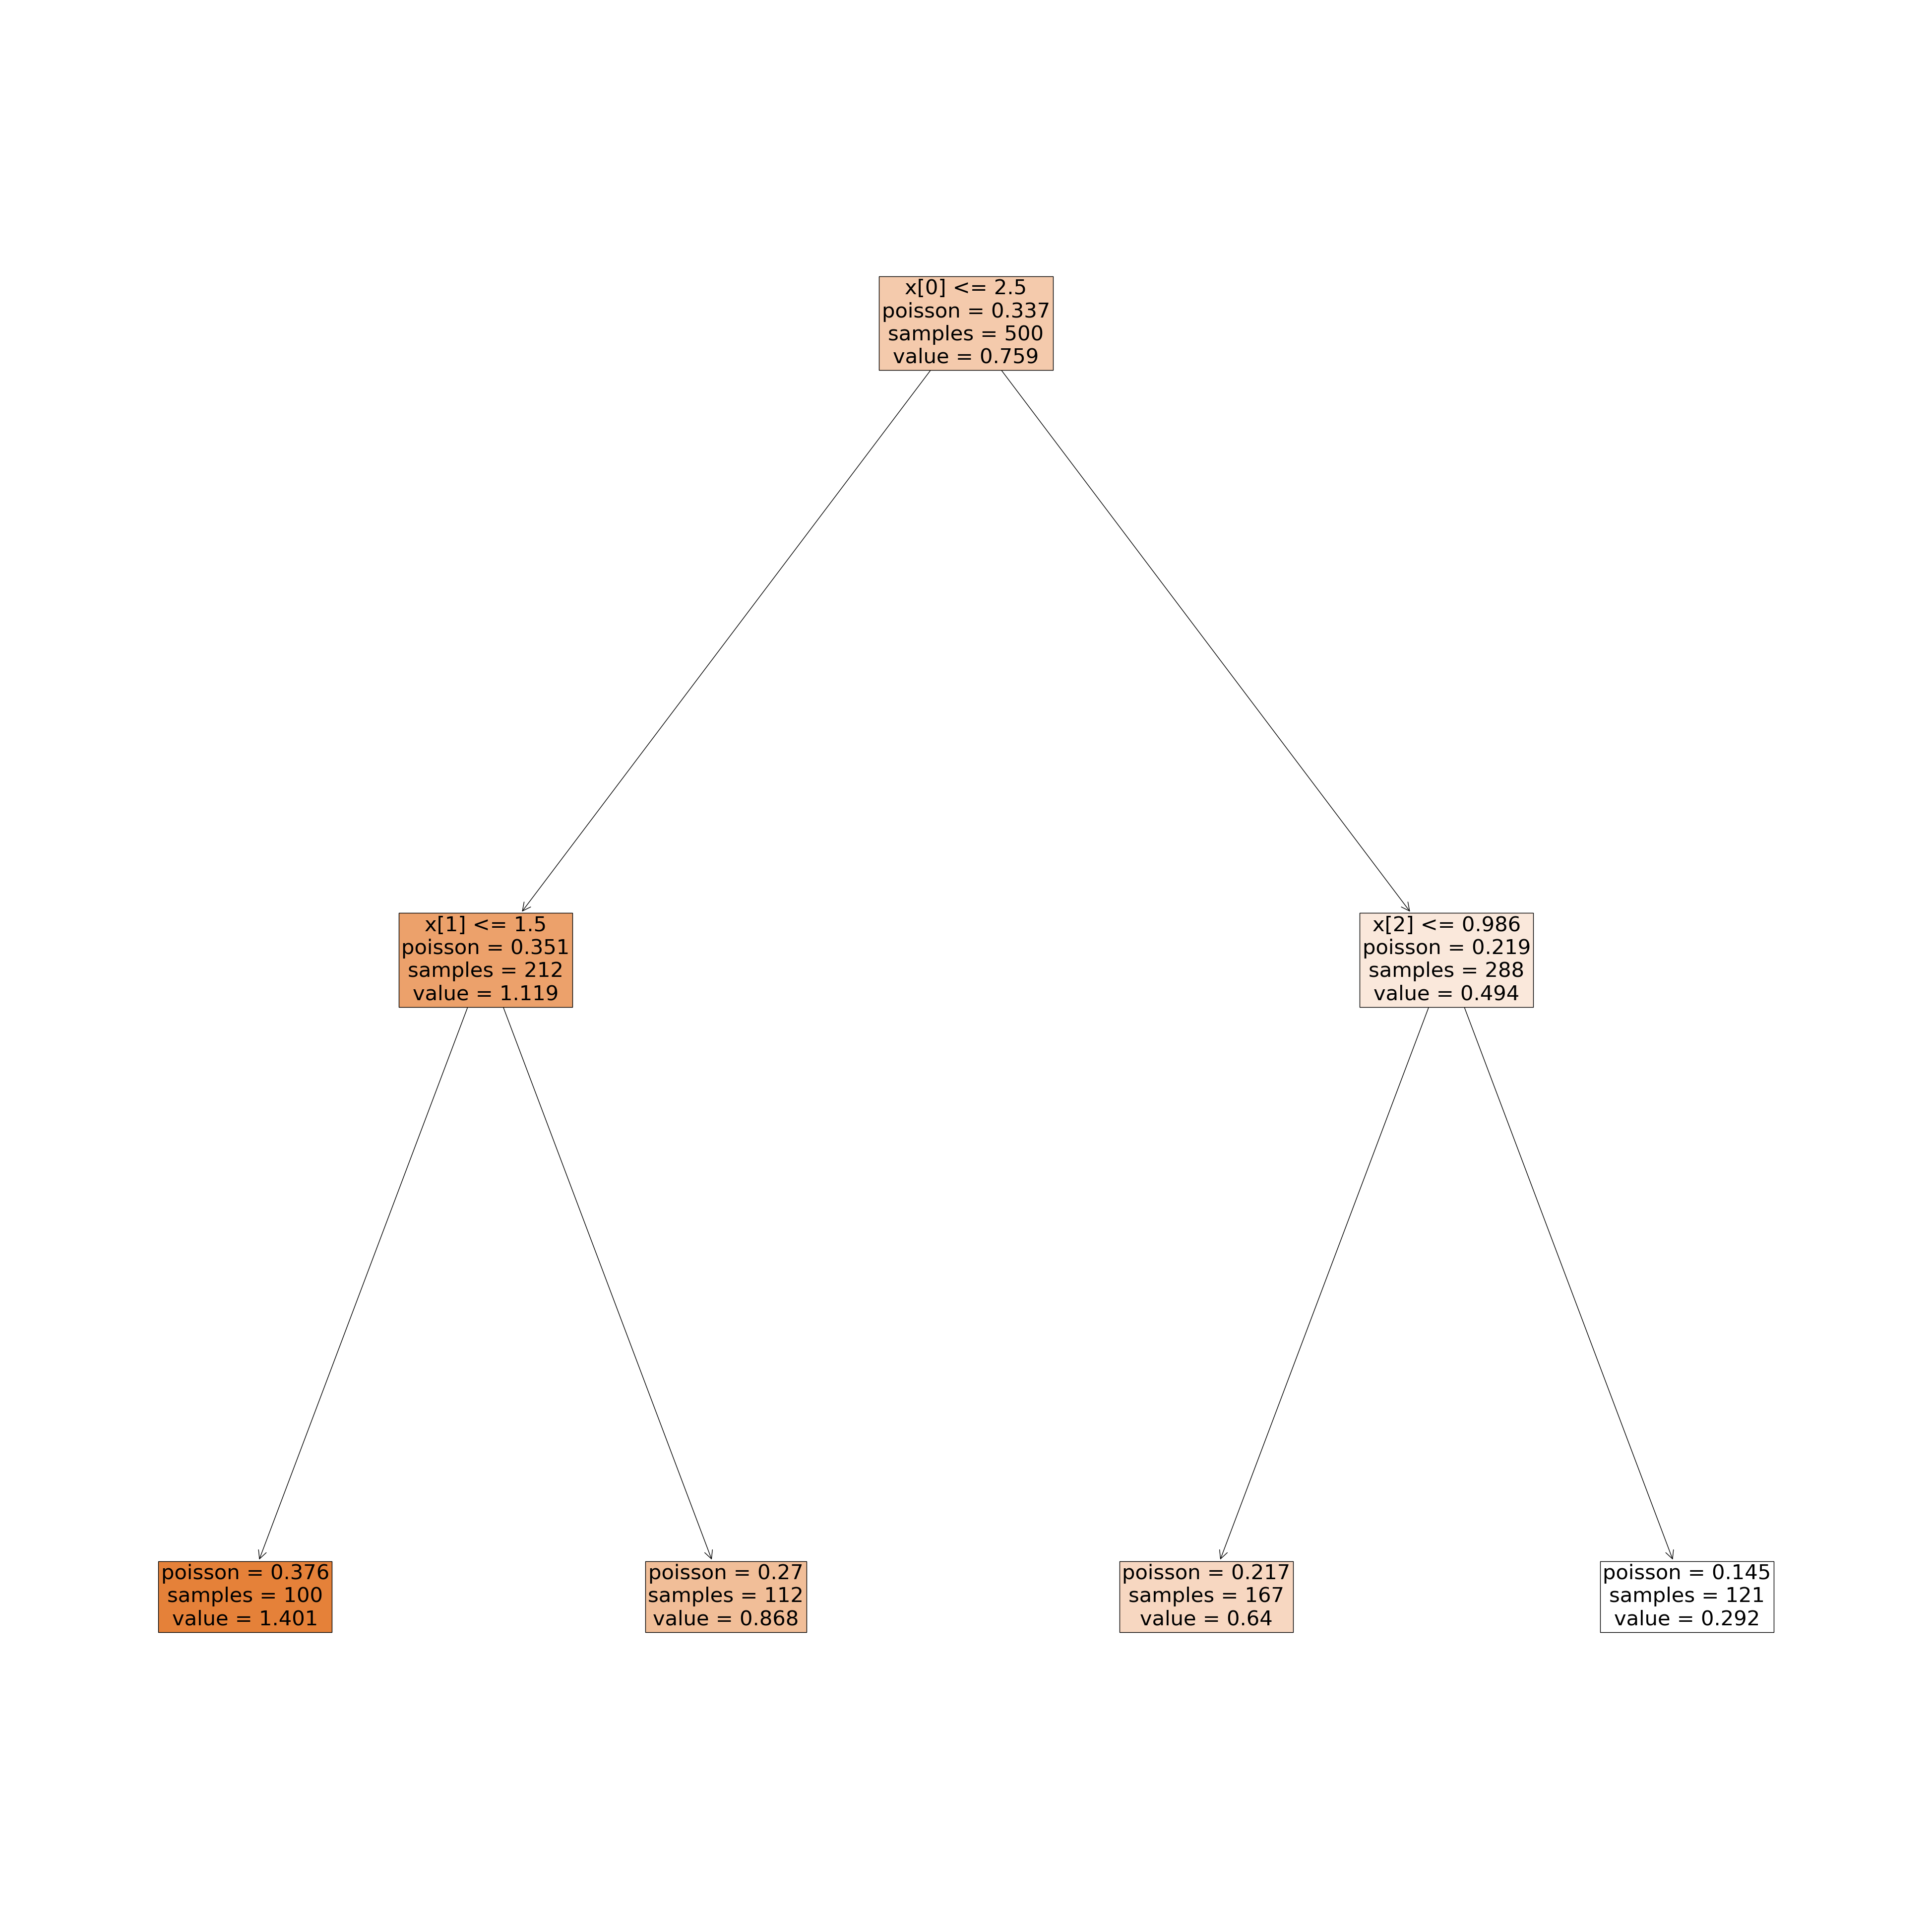

In [26]:

y_light,x_light = create_sim_data()


y_light,x_light = y_light.iloc[:500],x_light.iloc[:500]
surv_data = SurvivalData(y_light)
ltrc_art_tree =LTRCart(surv_data,x_light, control = {"max_depth":30, "min_samples_split":20, "min_samples_leaf":round(20/3)})
ltrc_art_tree = ltrc_art_tree.ltrc_art_fit()
fig = plt.figure(figsize=(50,50))
tree.plot_tree(ltrc_art_tree,fontsize=30,filled = True)





In [10]:
def printTree(root, markerStr="+- ", levelMarkers=[]):
    emptyStr = " "*len(markerStr)
    connectionStr = "|" + emptyStr[:-1]
    level = len(levelMarkers)
    mapper = lambda draw: connectionStr if draw else emptyStr
    markers = "".join(map(mapper, levelMarkers[:-1]))
    markers += markerStr if level > 0 else ""
    print(f"{markers}{root.x}")
    for i, child in enumerate(root.children):
        isLast = i == len(root.children) - 1
        printTree(child, markerStr, [*levelMarkers, not isLast])

# Brier score

In [11]:
y, X = create_sim_data()
new_y = y[['event','t']].to_numpy()
#List of tuples
aux = [(e1,e2) for e1,e2 in new_y]

#Structured array
new_y= np.array(aux, dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

est = CoxPHSurvivalAnalysis(ties="efron").fit(X, new_y)
survs = est.predict_survival_function(X)
times = y.t.loc[:300]
preds = np.asarray([[fn(t) for t in times] for fn in survs])
score = integrated_brier_score(new_y, new_y, preds, times)
print(score)

0.2895404797410931


In [ ]:
def cox_ibs(y,X):

    # y, X = y.iloc[:300], X.iloc[:300]
    new_y = y[['event','t']].to_numpy()
    #List of tuples
    aux = [(e1,e2) for e1,e2 in new_y]

    #Structured array
    new_y= np.array(aux, dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

    est_5 = CoxPHSurvivalAnalysis(ties="efron").fit(X, new_y)
    survs_5 = est.predict_survival_function(X)
    est_6 = CoxPHFitter(penalizer=0).fit(df=y, duration_col='t', event_col='event', entry_col='lt')
    survs_6 = est_6.predict_survival_function(X)
    times = y.loc[((y.event==1) & (y.t<y.t.max())),'t']
    
    preds_5 = np.asarray([[fn(t) for t in times] for fn in survs_5])
    preds_6 = np.asarray([[fn[t] for t in times] for fn in survs_6])

    score_5 = integrated_brier_score(new_y, new_y, pred_5, times)
    score_6 = integrated_brier_score(new_y, new_y, preds_6, times)
    return score_5,score_6

In [12]:
y, X = create_sim_data()

array([[0.51205026, 0.96379513, 0.6434624 , ..., 0.6391052 , 0.86981203,
        0.29194785],
       [0.20873639, 0.91730468, 0.35630089, ..., 0.35067921, 0.72146486,
        0.05603493],
       [0.5185048 , 0.96446051, 0.64879373, ..., 0.64448238, 0.87208549,
        0.29875284],
       ...,
       [0.23013172, 0.92224949, 0.37995455, ..., 0.37433028, 0.73628532,
        0.06705175],
       [0.39575202, 0.9502114 , 0.54302671, ..., 0.5379409 , 0.82434583,
        0.18175827],
       [0.3777275 , 0.94777418, 0.5266063 , ..., 0.52142748, 0.81637709,
        0.16682306]])

In [13]:
ibs = []
for i in range(1):
    y_i = y.sample(300)
    x_i = X.loc[y_i.index]
    avg = cox_ibs(y_i,x_i)
    ibs.append(avg)

0      4.948606
1      0.614461
2      3.232760
3      1.508312
4      1.156386
         ...   
295    5.021628
296    4.040801
298    3.283915
299    1.265601
300    9.596900
Name: t, Length: 252, dtype: float64

In [ ]:

# Import libraries
import matplotlib.pyplot as plt
import numpy as np
 
 
# Creating dataset
np.random.seed(10)
data = np.random.normal(100, 20, 200)
 
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(ibs)
 
# show plot
plt.show()